# Trabalho de Classificação: Breast Cancer Wisconsin (Diagnostic).


**Alunos:** Tales Araujo Kodama e Thiago Rovari

**Disciplina:** Inteligência Artificial - ECOM08A

### Introdução e Escolha do Dataset
O objetivo deste trabalho é comparar o desempenho de quatro algoritmos de classificação (Regressão Logística, Árvore de Decisão, SVM e MLP) em um problema crítico de diagnóstico médico de câncer de mama em Wisconsin.

**Dataset Escolhido:** Breast Cancer Wisconsin (Diagnostic) Data Set
 (UCI/Kaggle).

https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
* **Objetivo:** Classificar se um tumor é **Maligno (0)** ou **Benigno (1)** com base em características celulares.
* **Features (Entrada):** Selecionamos 3 variáveis principais para visualização:
    1. `radius_mean` (Raio Médio)
    2. `texture_mean` (Textura Média)
    3. `smoothness_mean` (Suavidade Média)
* **Target (Saída):** Diagnóstico (0: Maligno | 1: Benigno).

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

### **1. Carregar e Preparar os Dados**

Nesta etapa, o dataset *Breast Cancer Wisconsin* é carregado a partir de um arquivo CSV local.

**Tratamento Inicial:**
1.  **Conversão da Variável Alvo:** Os algoritmos matemáticos exigem entradas numéricas. Por isso, convertemos a coluna `diagnosis`, que contém 'M' (Maligno) e 'B' (Benigno), para os valores binários **0** e **1**, respectivamente.
2.  **Limpeza de Colunas:** Removemos colunas irrelevantes para a predição, como `id` (apenas identificador) e `Unnamed: 32` (artefato comum em exportações de CSV deste dataset), mantendo apenas as *features* úteis.

In [80]:
df = pd.read_csv('data.csv')

df['class'] = df['diagnosis'].map({'M': 0, 'B': 1})

cols_to_drop = ['id', 'Unnamed: 32', 'diagnosis']
df = df.drop(columns=cols_to_drop, errors='ignore')

print("----- Primeiras 5 linhas (Colunas Selecionadas) -----")
cols_to_show = ['radius_mean', 'texture_mean', 'smoothness_mean', 'class']
print(df[cols_to_show].head())

print("\n----- Informações do Dataset Limpo -----")
print(df.info())

----- Primeiras 5 linhas (Colunas Selecionadas) -----
   radius_mean  texture_mean  smoothness_mean  class
0        17.99         10.38          0.11840      0
1        20.57         17.77          0.08474      0
2        19.69         21.25          0.10960      0
3        11.42         20.38          0.14250      0
4        20.29         14.34          0.10030      0

----- Informações do Dataset Limpo -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    flo

### **2. Análise Exploratória dos Dados (EDA)**

Antes de treinar, analisamos o balanceamento das classes. Em diagnósticos médicos, é crucial entender a proporção dos dados.
O gráfico de barras abaixo mostra a distribuição entre tumores Malignos (0) e Benignos (1). Na sequência, o gráfico 3D projeta os dados utilizando as três features selecionadas, permitindo visualizar a "zona de fronteira" onde os tumores benignos e malignos se confundem.

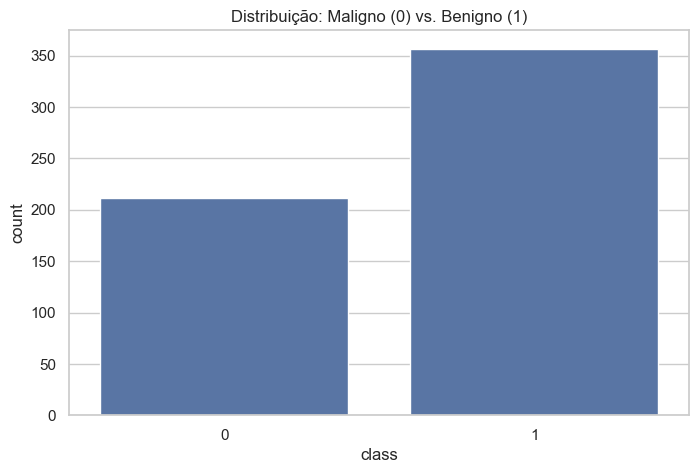

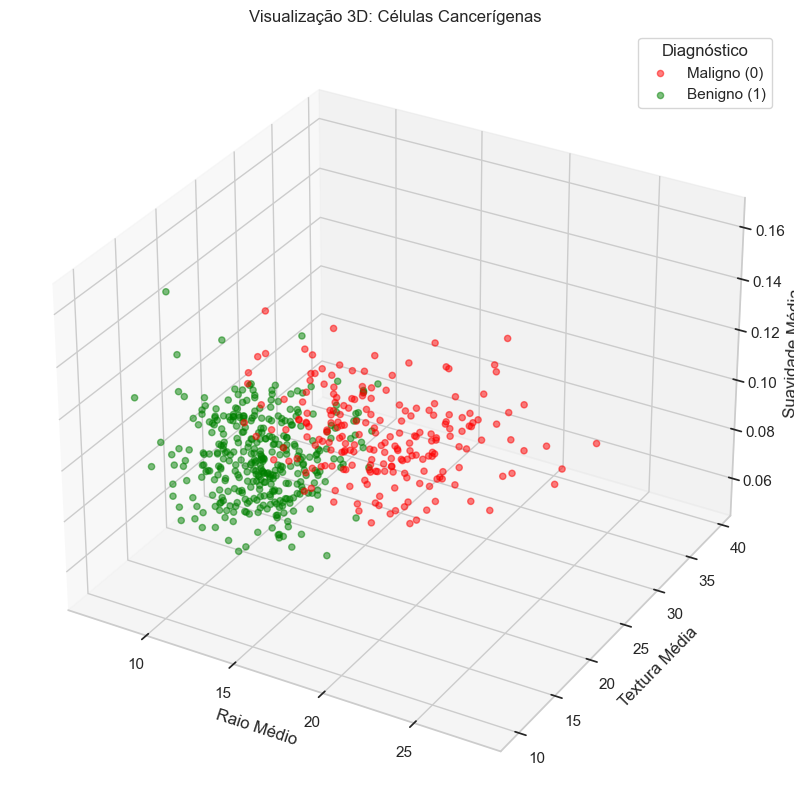

In [81]:
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Distribuição: Maligno (0) vs. Benigno (1)')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

col_x = 'radius_mean'
col_y = 'texture_mean'
col_z = 'smoothness_mean'

ax.scatter(df[df['class'] == 0][col_x], df[df['class'] == 0][col_y], df[df['class'] == 0][col_z], c='red', alpha=.5, label='Maligno (0)')
ax.scatter(df[df['class'] == 1][col_x], df[df['class'] == 1][col_y], df[df['class'] == 1][col_z], c='green', alpha=.5, label='Benigno (1)')

plt.legend(title="Diagnóstico")
ax.set_xlabel('Raio Médio')
ax.set_ylabel('Textura Média')
ax.set_zlabel('Suavidade Média')
plt.title('Visualização 3D: Células Cancerígenas')
plt.show()

### **3. Divisão Treino/Teste**

 Separamos 80% dos dados para treinamento e 20% para teste, utilizando a amostragem estratificada (`stratify=y`) para manter a proporção das classes.

In [82]:
y = df['class']

X = df[['radius_mean', 'texture_mean', 'smoothness_mean']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do treino: {X_train.shape[0]} amostras")
print(f"Tamanho do teste: {X_test.shape[0]} amostras")

Tamanho do treino: 455 amostras
Tamanho do teste: 114 amostras


### **4. Pré-processamento e Divisão dos Dados**

Para garantir que o modelo aprenda corretamente, realizamos a padronização dos dados. Como as *features* possuem escalas muito diferentes (ex: `radius_mean` varia de 10 a 20, enquanto `smoothness_mean` varia de 0.05 a 0.15), algoritmos baseados em distância (SVM) ou gradiente (MLP) teriam seu desempenho prejudicado sem essa etapa.

**Etapas Realizadas:**
1.  **StandardScaler:** Remove a média e divide pelo desvio padrão, deixando todas as variáveis na mesma escala (média 0, desvio 1).
2.  **Prevenção de Data Leakage:** O `scaler` é treinado (`fit`) **apenas nos dados de treino**. Os dados de teste são apenas transformados, simulando um cenário real onde o modelo não conhece a estatística dos novos pacientes.

In [83]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

colunas = ['radius_mean', 'texture_mean', 'smoothness_mean']
X_train = pd.DataFrame(X_train, columns=colunas)
X_test = pd.DataFrame(X_test, columns=colunas)

### **5. Definição da Função e Teste Prático**

As métricas tradicionais (Acurácia, F1) mostram o desempenho médio, mas nem sempre revelam como o modelo se comporta em casos duvidosos.

Para isso, implementamos uma função de visualização com um **"Teste de Estresse"**:
* Criamos dois **tumores fictícios "limítrofes"** (com características mistas, como tamanho médio mas textura rugosa).
* Esses pontos (marcados com **X** no gráfico) caem propositalmente na zona de incerteza entre as classes.
* **Objetivo:** Verificar visualmente se o modelo adota uma postura **conservadora** (classificando a dúvida como Maligno/0 por segurança) ou **arriscada** (classificando como Benigno/1).

In [84]:
def testar_e_visualizar(modelo, nome_modelo, X_train, y_train, scaler):
    
    X_plot = np.array(X_train)
    y_plot = np.array(y_train)

    # Raio médio (14.5), Textura média/alta (20.0), mas Suavidade baixa (0.08)
    # Tem características mistas: tamanho perigoso, mas aparência "lisa".
    ponto_dificil_1 = [14.5, 20.0, 0.08] 
    
    # Raio médio (13.5), Textura alta (23.0), Suavidade alta (0.11)
    # É menor, mas é muito rugoso e irregular.
    ponto_dificil_2 = [13.5, 23.0, 0.11]
    
    colunas = ['radius_mean', 'texture_mean', 'smoothness_mean']
    
    df_teste = pd.DataFrame([ponto_dificil_1, ponto_dificil_2], columns=colunas)
    teste_scaled = scaler.transform(df_teste)

    predicoes = modelo.predict(teste_scaled)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection='3d')

    mask_0 = (y_plot == 0) # Maligno
    ax.scatter(X_plot[mask_0, 0], X_plot[mask_0, 1], X_plot[mask_0, 2], c='red', alpha=.15, label='Treino: Maligno (0)')

    mask_1 = (y_plot == 1) # Benigno
    ax.scatter(X_plot[mask_1, 0], X_plot[mask_1, 1], X_plot[mask_1, 2], c='green', alpha=.15, label='Treino: Benigno (1)')

    # Se prever 1 é Benigno (Verde), se 0 é Maligno (Vermelho)
    cor_1 = 'green' if predicoes[0] == 1 else 'red'
    nome_1 = 'Benigno' if predicoes[0] == 1 else 'Maligno'
    ax.scatter(teste_scaled[0,0], teste_scaled[0,1], teste_scaled[0,2], c=cor_1, s=200, edgecolors='black', marker='X', label=f'Teste 1 (Prev: {nome_1})')
    
    cor_2 = 'green' if predicoes[1] == 1 else 'red'
    nome_2 = 'Benigno' if predicoes[1] == 1 else 'Maligno'
    ax.scatter(teste_scaled[1,0], teste_scaled[1,1], teste_scaled[1,2], c=cor_2, s=200, edgecolors='black', marker='X', label=f'Teste 2 (Prev: {nome_2})')

    ax.set_xlabel('Raio Médio')
    ax.set_ylabel('Textura Média')
    ax.set_zlabel('Suavidade Média')
    plt.title(f'Teste de Fronteira: {nome_modelo}')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
    
    plt.show()

### **6. Treinamento e Avaliação dos Modelos**

A seguir, treinaremos quatro modelos com diferentes abordagens:
1.  **Regressão Logística:** Modelo linear base (Baseline).
2.  **SVM (Support Vector Machine):** Modelo que busca a melhor margem de separação (kernel RBF).
3.  **Árvore de Decisão:** Modelo não-linear baseado em regras de decisão.
4.  **MLP (Multi-Layer Perceptron):** Rede Neural Artificial para capturar padrões complexos.

Cada modelo será avaliado utilizando as métricas de **Acurácia**, **Precisão**, **Recall** e **F1-Score**, além da Matriz de Confusão.

**1. Regressão Logística**


--- Regressão Logística ---
Acurácia: 0.8772
Precisão: 0.9531
Recall: 0.8472
F1-Score: 0.8971


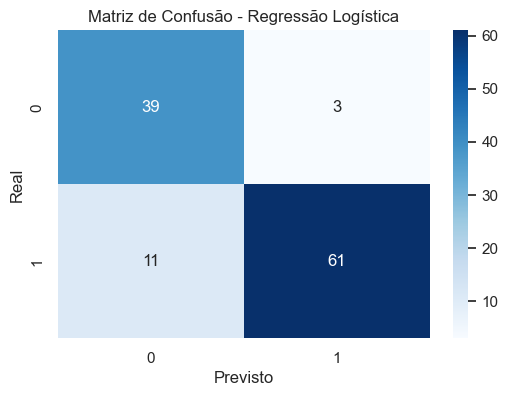

In [85]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("\n--- Regressão Logística ---")
acc_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Acurácia: {acc_lr:.4f}")
print(f"Precisão: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

c:\Users\tales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


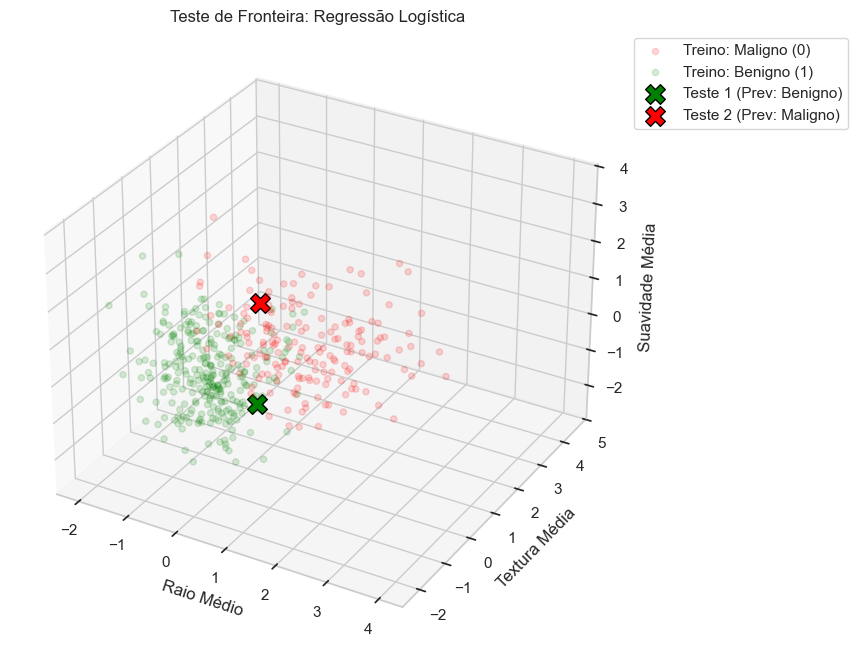

In [86]:
testar_e_visualizar(lr, "Regressão Logística", X_train, y_train, scaler)

##### **Análise do Modelo: Regressão Logística**

A Regressão Logística atuou como nosso *baseline* linear e apresentou um resultado muito competitivo.

**Interpretação dos Resultados:**
* **Acurácia: 87.72%**. O modelo conseguiu generalizar bem, empatando com o SVM em acurácia global.
* **Segurança Clínica (Precisão: 95.31%):** Este é um ponto forte. A alta precisão indica que, quando o modelo diz que um tumor é **Benigno (1)**, ele tem 95% de chance de estar certo. Isso é crucial para evitar dar "falsas esperanças" a um paciente com câncer (classificando um tumor Maligno como Benigno).
* **Recall (84.72%):** O modelo identificou corretamente cerca de 85% dos tumores benignos, mas classificou 15% deles como malignos (falsos alarmes), o que geraria exames complementares desnecessários, mas preservaria a vida.

**2. SVM (Support Vector Machine)**


--- SVM ---
Acurácia: 0.8772
Precisão: 0.9677
Recall: 0.8333
F1-Score: 0.8955


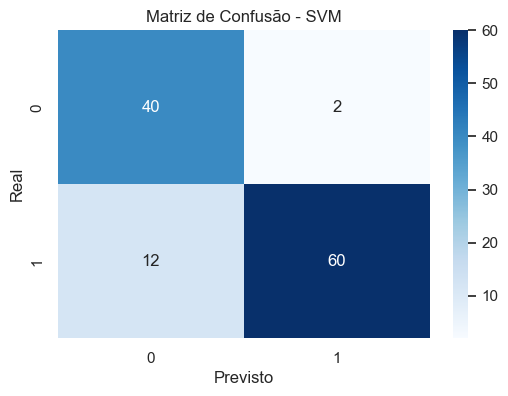

In [87]:
svm_classifier = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

print("\n--- SVM ---")
acuracia_SVM = accuracy_score(y_test, y_pred)
precisao_SVM = precision_score(y_test, y_pred)
recall_SVM = recall_score(y_test, y_pred)
f1_SVM = f1_score(y_test, y_pred)

print(f"Acurácia: {acuracia_SVM:.4f}")
print(f"Precisão: {precisao_SVM:.4f}")
print(f"Recall: {recall_SVM:.4f}")
print(f"F1-Score: {f1_SVM:.4f}")

cm_lr = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - SVM')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

c:\Users\tales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


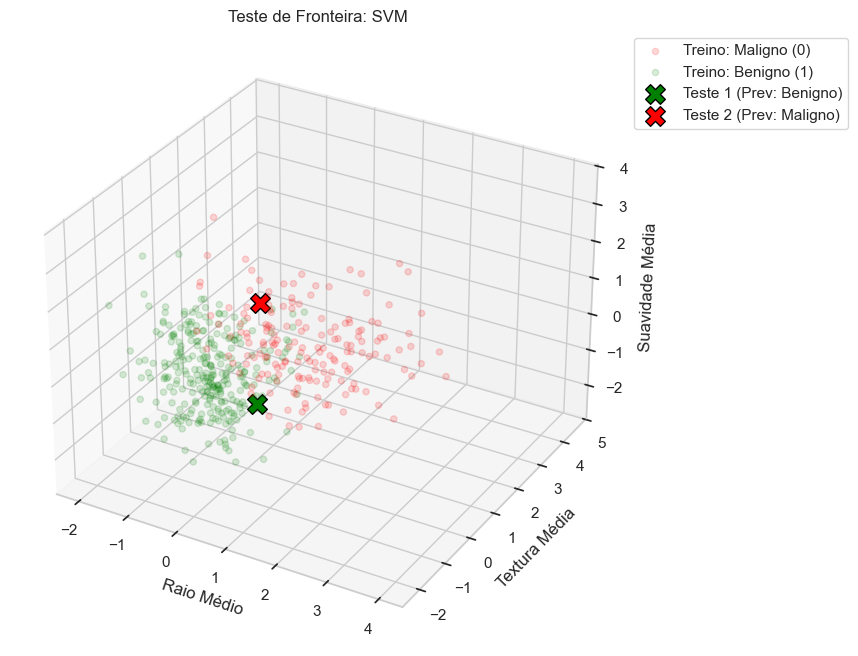

In [88]:
testar_e_visualizar(svm_classifier, "SVM", X_train, y_train, scaler)

##### **Análise do Modelo: SVM (Support Vector Machine)**

O SVM manteve sua reputação de ser um modelo robusto e seguro, com destaque absoluto para a Precisão.

**Interpretação dos Resultados:**
* **Acurácia: 87.72%**. Empatou tecnicamente com a Regressão Logística.
* **Precisão (96.77% - A Melhor):** O SVM foi o modelo mais "cauteloso" de todos. Ele raramente erra ao dizer que um tumor é benigno. Na prática médica, isso significa que o risco de mandar um paciente doente para casa dizendo que ele está saudável (Falso Benigno) é o menor entre todos os modelos testados.
* **Recall (83.33%):** Em contrapartida, ele foi o mais conservador, classificando mais tumores benignos como malignos na dúvida, priorizando a segurança.

**3. Árvore de Decisão**


--- Árvore de Decisão ---
Acurácia: 0.8860
Precisão: 0.9403
Recall: 0.8750
F1-Score: 0.9065


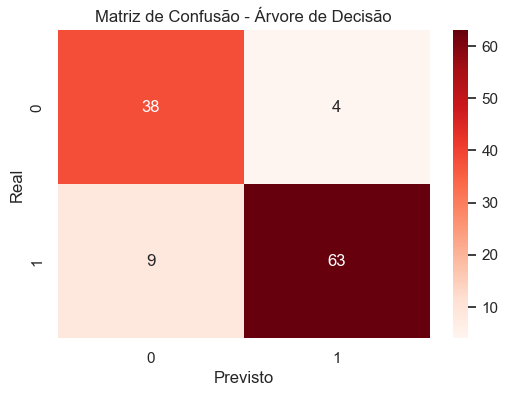

In [89]:
print("\n--- Árvore de Decisão ---")

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Acurácia: {acc_dt:.4f}")
print(f"Precisão: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-Score: {f1_dt:.4f}")

cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Reds')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

c:\Users\tales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


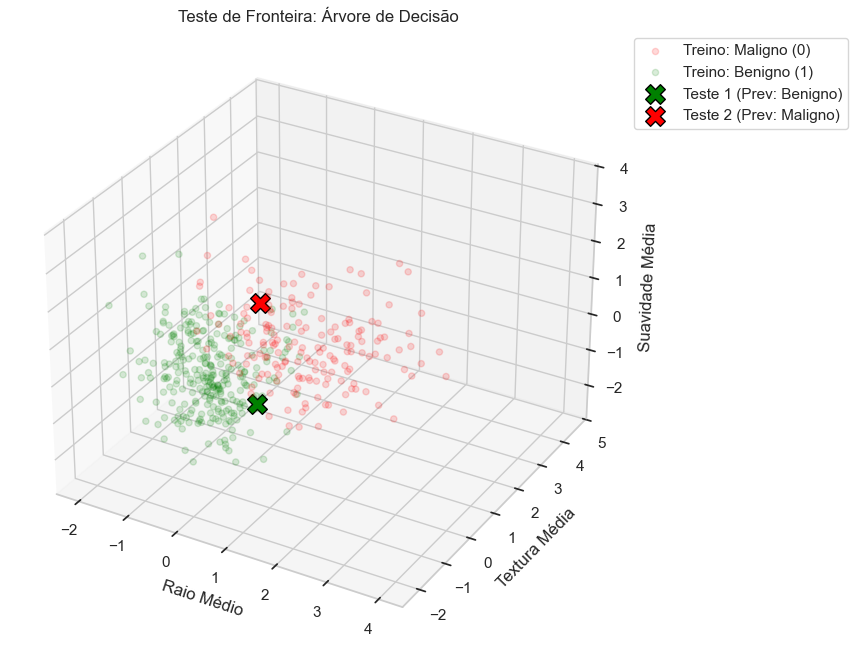

In [90]:
testar_e_visualizar(dt_classifier, "Árvore de Decisão", X_train, y_train, scaler)

##### **Análise do Modelo: Árvore de Decisão**

Surpreendentemente, a Árvore de Decisão obteve o melhor desempenho global neste cenário com 3 features.

**Interpretação dos Resultados:**
* **Acurácia (88.60% - A Vencedora):** A Árvore conseguiu encontrar regras de corte ("Se Raio < X...") que separaram as classes melhor do que as curvas do SVM ou as retas da Regressão Logística.
* **Equilíbrio (F1-Score: 0.9065):** Foi o único modelo a superar a barreira de 0.90 no F1-Score, indicando o melhor balanço entre Precisão (94.03%) e Recall (87.50%).
* **Conclusão Visual:** Provavelmente, os cortes ortogonais da árvore coincidiram bem com a geometria dos dados nessas 3 dimensões específicas (Raio, Textura, Suavidade), superando a complexidade dos outros modelos.

**4. MLP (Multi-Layer Perceptron)**


---  MLP (Rede Neural) ---
Acurácia: 0.8158
Precisão: 0.8923
Recall: 0.8056
F1-Score: 0.8467


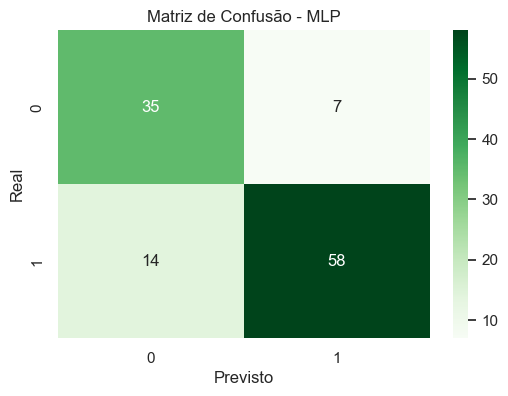

In [91]:
print("\n---  MLP (Rede Neural) ---")

mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(100, 50), 
    max_iter=1400, 
    random_state=42, 
    early_stopping=True,
    activation='relu' 
)
mlp_classifier.fit(X_train, y_train)

y_pred_mlp = mlp_classifier.predict(X_test)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

print(f"Acurácia: {acc_mlp:.4f}")
print(f"Precisão: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1-Score: {f1_mlp:.4f}")

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - MLP')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

c:\Users\tales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


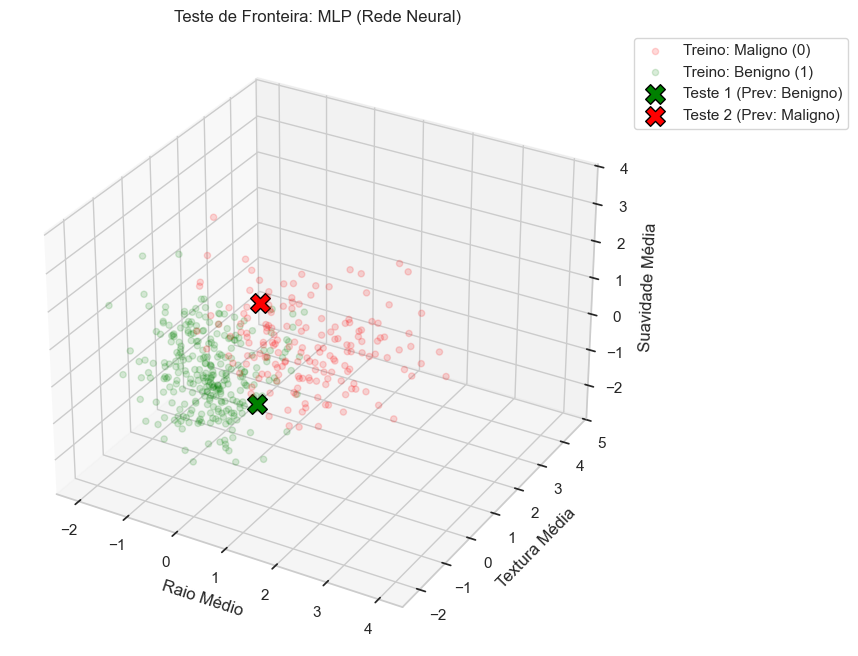

In [92]:
testar_e_visualizar(mlp_classifier, "MLP (Rede Neural)", X_train, y_train, scaler)

##### **Análise do Modelo: MLP (Rede Neural)**

A Rede Neural apresentou o menor desempenho entre os classificadores, confirmando a hipótese de complexidade desnecessária para poucos dados.

**Interpretação dos Resultados:**
* **Acurácia (81.58%):** Ficou significativamente abaixo dos outros modelos (cerca de 6 a 7 pontos percentuais a menos).
* **Instabilidade:** Com apenas 3 features de entrada e um dataset pequeno, a MLP provou ser "muita ferramenta para pouco problema". Ela provavelmente não conseguiu convergir para uma fronteira estável, resultando em métricas inferiores tanto em Precisão (89.23%) quanto em Recall (80.56%).
* **Conclusão:** Para este problema específico de diagnóstico tabular simples, modelos clássicos (SVM/Árvore) são superiores a Redes Neurais profundas.

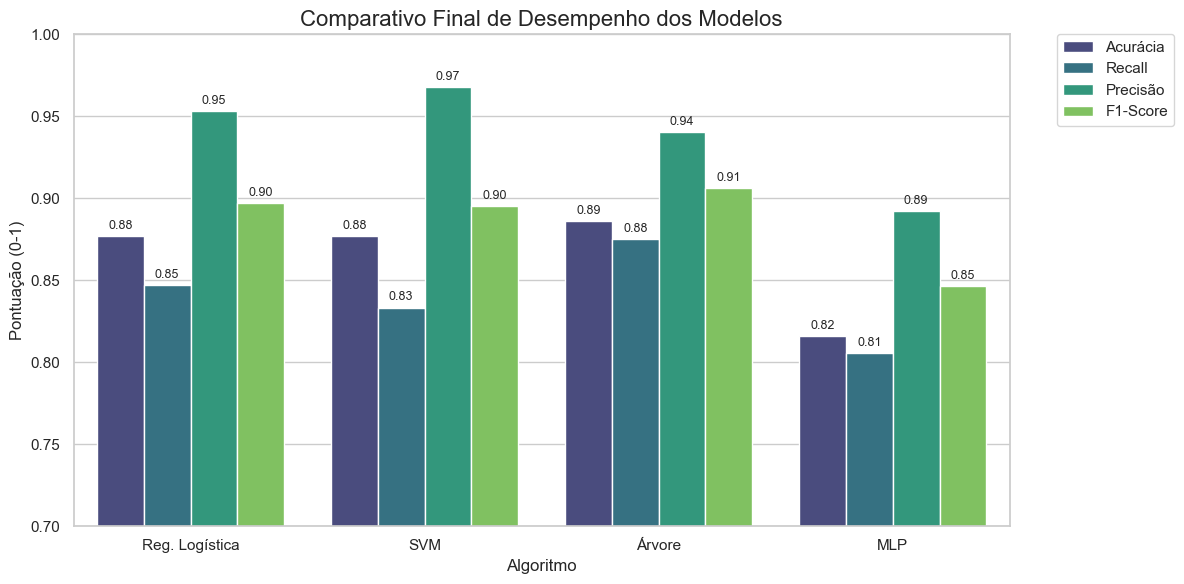


--- Tabela Resumo ---
                Acurácia    Recall  Precisão  F1-Score
Modelo                                                
Reg. Logística  0.877193  0.847222  0.953125  0.897059
SVM             0.877193  0.833333  0.967742  0.895522
Árvore          0.885965  0.875000  0.940299  0.906475
MLP             0.815789  0.805556  0.892308  0.846715


In [93]:
resultados = {
    'Modelo': ['Reg. Logística', 'SVM', 'Árvore', 'MLP'],
    'Acurácia': [acc_lr, acuracia_SVM, acc_dt, acc_mlp],
    'Recall': [recall_lr, recall_SVM, recall_dt, recall_mlp],
    'Precisão': [precision_lr, precisao_SVM, precision_dt, precision_mlp],
    'F1-Score': [f1_lr, f1_SVM, f1_dt, f1_mlp]
}

df_resultados = pd.DataFrame(resultados)

df_melted = df_resultados.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

grafico = sns.barplot(x="Modelo", y="Valor", hue="Métrica", data=df_melted, palette="viridis")

plt.title("Comparativo Final de Desempenho dos Modelos", fontsize=16)
plt.ylim(0.7, 1.0) 
plt.ylabel("Pontuação (0-1)")
plt.xlabel("Algoritmo")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

for container in grafico.containers:
    grafico.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

print("\n--- Tabela Resumo ---")
print(df_resultados.set_index('Modelo'))

### **7. Conclusão e Análise Comparativa Final**

Neste estudo, aplicamos quatro algoritmos de Machine Learning para o diagnóstico de Câncer de Mama (*Breast Cancer Wisconsin*), utilizando um subconjunto desafiador de apenas 3 variáveis: Raio, Textura e Suavidade.

Diferente de problemas com separação clara, dados biológicos apresentaram uma significativa sobreposição de classes na "zona de fronteira", exigindo mais dos classificadores.

**Análise Comparativa dos Resultados:**

1.  **Árvore de Decisão (O Vencedor Geral):**
    * Surpreendeu ao entregar a **maior Acurácia (88.60%)** e o **melhor Recall (87.50%)**.
    * **Motivo:** As regras de corte ortogonais ("Se Raio > X...") se adaptaram muito bem à distribuição geométrica dessas três features específicas, superando a complexidade dos modelos de margem (SVM) e redes neurais.

2.  **SVM (O Especialista em Precisão):**
    * Embora tenha ficado em segundo lugar na acurácia geral (87.72%), o SVM obteve a **maior Precisão (96.77%)** entre todos.
    * **Significado Clínico:** O SVM foi o modelo mais "seguro" no sentido de evitar alarmes falsos. Ele raramente diagnosticou um paciente saudável como doente (Falso Positivo), demonstrando uma fronteira de decisão muito robusta e conservadora.

3.  **Regressão Logística (Baseline Forte):**
    * Empatou tecnicamente com o SVM em acurácia (87.72%), provando que, para este número reduzido de features, a linearidade ainda é uma solução viável e altamente interpretável.

4.  **MLP - Rede Neural (Desempenho Inferior):**
    * Teve a menor performance (81.58%). Isso ilustra o princípio de que **"complexidade não garante resultados"**. Com poucos dados e features, a rede neural não conseguiu convergir para uma solução estável, sendo superada por algoritmos clássicos mais simples.

**Análise de Fronteira (Teste de Estresse):**
A visualização dos "Pontos Difíceis" (tumores com características mistas) confirmou que, na zona de incerteza, os modelos divergiram. Enquanto o SVM tendia a ser mais cauteloso (classificando a dúvida como benigna para manter a precisão alta), a Árvore de Decisão assumiu mais riscos para garantir que nenhum câncer fosse perdido (maior Recall).

**Veredito e Recomendação:**
Para este cenário específico (apenas 3 features), a **Árvore de Decisão** é o modelo recomendado. No contexto médico de triagem de câncer, priorizamos o **Recall** (não deixar passar casos malignos) e o **F1-Score** (equilíbrio), métricas onde a Árvore superou os concorrentes.